In [1]:
import gradio as gr
import torch
from src.train import train

In [2]:
model,data = train()

Target labels: [0 1]


wandb: Currently logged in as: lamastico2-0 (lamastico2-0-hes-so-valais-wallis) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: Detected [huggingface_hub.inference] in use.
wandb: Use W&B Weave for improved LLM call tracing. Install Weave with `pip install weave` then add `import weave` to the top of your script.
wandb: For more information, check out the docs at: https://weave-docs.wandb.ai/


lr: 0.0001
Epoch 01 | Loss: 0.7517 | Acc: 0.3724 | Val Loss: 0.7510 | Val Acc: 0.3772
Epoch 02 | Loss: 0.7514 | Acc: 0.3724 | Val Loss: 0.7507 | Val Acc: 0.3772
Epoch 03 | Loss: 0.7511 | Acc: 0.3724 | Val Loss: 0.7505 | Val Acc: 0.3772
Epoch 04 | Loss: 0.7509 | Acc: 0.3724 | Val Loss: 0.7502 | Val Acc: 0.3772
Epoch 05 | Loss: 0.7506 | Acc: 0.3724 | Val Loss: 0.7500 | Val Acc: 0.3772
Epoch 06 | Loss: 0.7503 | Acc: 0.3724 | Val Loss: 0.7497 | Val Acc: 0.3772
Epoch 07 | Loss: 0.7501 | Acc: 0.3724 | Val Loss: 0.7495 | Val Acc: 0.3772
Epoch 08 | Loss: 0.7498 | Acc: 0.3724 | Val Loss: 0.7492 | Val Acc: 0.3772
Epoch 09 | Loss: 0.7495 | Acc: 0.3724 | Val Loss: 0.7490 | Val Acc: 0.3772
Epoch 10 | Loss: 0.7493 | Acc: 0.3724 | Val Loss: 0.7487 | Val Acc: 0.3772
Epoch 11 | Loss: 0.7490 | Acc: 0.3724 | Val Loss: 0.7484 | Val Acc: 0.3772
Epoch 12 | Loss: 0.7487 | Acc: 0.3724 | Val Loss: 0.7482 | Val Acc: 0.3772
Epoch 13 | Loss: 0.7485 | Acc: 0.3724 | Val Loss: 0.7479 | Val Acc: 0.3772
Epoch 14 | Los

Train Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Loss,████▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
Val Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Val Loss,████▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
Train Accuracy,0.37243
Train Loss,0.73813
Val Accuracy,0.37719
Val Loss,0.73757


In [3]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [4]:
model.eval()
with torch.no_grad():
    y_pred_probs = model(data["X_test"])
    y_pred = (y_pred_probs > 0.5).int()

In [5]:
y_pred_np = y_pred.numpy().flatten()
y_true_np = data["y_test"].numpy().flatten()

print(classification_report(y_true_np, y_pred_np, target_names=["malignant", "benign"]))


              precision    recall  f1-score   support

   malignant       0.37      1.00      0.54        42
      benign       0.00      0.00      0.00        72

    accuracy                           0.37       114
   macro avg       0.18      0.50      0.27       114
weighted avg       0.14      0.37      0.20       114



c:\Users\robin\OneDrive\Bureau\projetsemstre\xai-on-the-wall\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\robin\OneDrive\Bureau\projetsemstre\xai-on-the-wall\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\robin\OneDrive\Bureau\projetsemstre\xai-on-the-wall\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to co

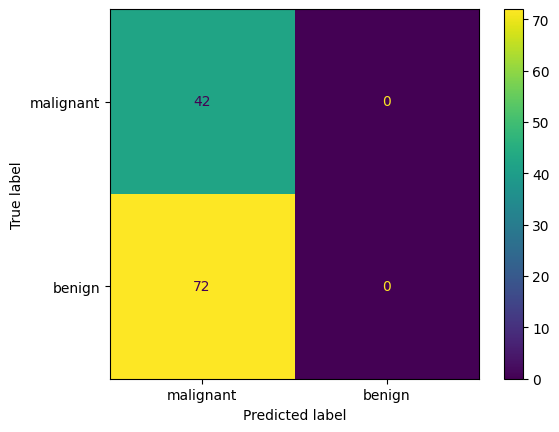

In [6]:
cm = confusion_matrix(y_true_np, y_pred_np)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["malignant", "benign"])
disp.plot()

In [7]:
import os
import sys
sys.path.insert(0, os.path.abspath('..'))

In [8]:
%load_ext autoreload
%autoreload 2
from dexire.dexire import DEXiRE

ModuleNotFoundError: No module named 'dill'

In [ ]:
from dexire.adapters.pytorch_adapter import PyTorchModelAdapter

In [ ]:
adapter = PyTorchModelAdapter(model)
dexire = DEXiRE(model=adapter, class_names=['malignant', 'benign'])
print("y_train unique values:", np.unique(y_train))
print("class_names:", dexire.class_names)

In [ ]:
rules = dexire.extract_rules(data["X_train"], data["y_train"])

In [ ]:
rules

In [ ]:
def greet(name, intensity):
    return "Hello, " + name + "!" * int(intensity)

In [ ]:
main = gr.Interface(
    fn=greet,
    inputs=["text", "slider"],
    outputs=["text"],
    api_name="predict"
)

In [ ]:
main.launch() # add share=True to have a public server 

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
